In [1]:
import pandas as pd
import json
from collections import defaultdict
import numpy as np
import math
from tqdm.notebook import tqdm_notebook as tqdm
import matplotlib.patches as pat
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
nations = pd.read_json('../public/nations.json')
nations

,name,region,income,population,lifeExpectancy
0,Angola,Sub-Saharan Africa,"[[1800, 359.93], [1820, 359.93], [1913, 556.12...","[[1800, 1567028], [1820, 1567028], [1940, 3738...","[[1800, 26.98], [1940, 26.98], [1950, 29.22], ..."
1,Benin,Sub-Saharan Africa,"[[1800, 553.72], [1820, 553.72], [1913, 855.53...","[[1800, 636559], [1820, 636559], [1950, 167266...","[[1800, 31], [1944, 31], [1950, 36.53], [1951,..."
2,Botswana,Sub-Saharan Africa,"[[1800, 407.36], [1820, 407.36], [1913, 629.4]...","[[1800, 121000], [1904, 121000], [1911, 125000...","[[1800, 33.6], [1945, 33.6], [1950, 46.82], [1..."
3,Burkina Faso,Sub-Saharan Africa,"[[1800, 454.33], [1820, 454.33], [1913, 497.44...","[[1800, 1665421], [1820, 1665421], [1950, 4376...","[[1800, 29.2], [1945, 29.2], [1950, 32.89], [1..."
4,Burundi,Sub-Saharan Africa,"[[1800, 447.59], [1820, 447.59], [1913, 353.82...","[[1800, 899097], [1820, 899097], [1950, 236252...","[[1800, 31.5], [1945, 31.5], [1950, 38.42], [1..."
...,...,...,...,...,...
175,Timor-Leste,East Asia & Pacific,"[[1800, 514.12], [1820, 518.73], [1850, 539.86...","[[1800, 137262], [1820, 137262], [1926, 442000...","[[1950, 28.97], [1951, 29.22], [1952, 29.73], ..."
176,Tokelau,East Asia & Pacific,"[[2005, 889.43]]","[[1800, 1009], [1843, 1000], [1850, 1000], [19...","[[2006, 69]]"
177,Tonga,East Asia & Pacific,"[[1800, 667.71], [1820, 667.71], [1913, 902.69...","[[1800, 18658], [1843, 18500], [1850, 18500], ...","[[1950, 57.91], [1951, 58.1], [1952, 58.47], [..."
178,Vietnam,East Asia & Pacific,"[[1800, 459.71], [1820, 459.71], [1870, 440.8]...","[[1800, 6551000], [1820, 6551000], [1870, 1052...","[[1800, 32], [1930, 32], [1936, 33], [1950, 39..."


In [3]:
inds = 'name year region income population lifeExpectancy'.split()
new_nations = pd.DataFrame({k: [] for k in inds}, index=[])
for nation in tqdm(nations.iterrows(), total=len(nations)):
    d = defaultdict(lambda: {k: None for k in inds[3:]})
    for k in inds[3:]:
        for year, v in nation[1][k]:
            d[year][k] = v
    for year in range(1800, 2010):
        d_tmp = dict(name=nation[1]['name'], year=year, region=nation[1]['region'])
        d_tmp.update(d[year])
        new_nations = new_nations.append(d_tmp, ignore_index=True)
new_nations = new_nations.astype({'name': str, 'year': int, 'region': str, 'income': float, 'population': float, 'lifeExpectancy': float})
new_nations['year'] = pd.to_datetime(new_nations['year'], format='%Y')
new_nations_ = new_nations.set_index(['name', 'year'])
new_nations__ = new_nations.set_index(['name', 'year', 'region'])
new_nations__

income  population  lifeExpectancy
name    year       region                                                  
Angola  1800-01-01 Sub-Saharan Africa    359.93   1567028.0           26.98
        1801-01-01 Sub-Saharan Africa       NaN         NaN             NaN
        1802-01-01 Sub-Saharan Africa       NaN         NaN             NaN
        1803-01-01 Sub-Saharan Africa       NaN         NaN             NaN
        1804-01-01 Sub-Saharan Africa       NaN         NaN             NaN
...                                         ...         ...             ...
Vanuatu 2005-01-01 East Asia & Pacific  3477.00    205754.0           69.26
        2006-01-01 East Asia & Pacific  3632.57    208869.0           69.58
        2007-01-01 East Asia & Pacific  3779.08    211971.0           69.89
        2008-01-01 East Asia & Pacific  3916.57    215053.0           70.20
        2009-01-01 East Asia & Pacific  3943.30         NaN           70.50

[37800 rows x 3 columns]

In [4]:
def c(ys):
    y_mean = np.mean(ys)
    return np.sum(np.abs(ys-y_mean))

def d(ys1, ys2):
    return c(pd.concat([ys1, ys2])) - c(ys1) - c(ys2)


# salient peaks
def A(ys, window_size, K=5):
    peaks = []
    for i in range(1, len(ys)-1):
        if max(ys[i-1], ys[i+1]) < ys[i]:
            peaks.append((int(max(0, i-window_size//2)), int(min(len(ys), i+window_size//2)), 'peak', d(ys[max(0, i-window_size//2):i], ys[i:i+window_size//2])))
        elif min(ys[i-1], ys[i+1]) > ys[i]:
            peaks.append((int(max(0, i-window_size//2)), int(min(len(ys), i+window_size//2)), 'valley', d(ys[max(0, i-window_size//2):i], ys[i:i+window_size//2])))
        else:
            pass
    peaks = sorted(peaks, key=lambda x: x[3])[::-1][:K]
    peaks = sorted(peaks, key=lambda x: x[0])
    ret = []
    if len(peaks)==0:
        return ret
    pre_from_, pre_to_, p_type_pre, v = peaks[0]
    if v == 0:
        return ret
    for from_, to_, p_type, v in peaks[1:]:
        if v == 0:
            ret.append((pre_from_, pre_to_, p_type_pre))
            break
        if pre_to_ >= from_:
            pre_to_ = to_
            if p_type_pre != p_type:
                p_type_pre = 'vibration'
        else:
            ret.append((pre_from_, pre_to_, p_type_pre))
            pre_from_, pre_to_, p_type_pre = from_, to_, p_type
    ret.append((pre_from_, pre_to_, p_type_pre))
    return ret


        
def get_grad(ys):
    if len(ys)==0:
        return 0
    ys = np.array(ys).reshape(-1)
    try:
        a, b = np.linalg.lstsq(np.array([[i, 1] for i in range(len(ys))]), ys)[0]
    except np.linalg.LinAlgError:
        a = 0
    return a


# trend changes
def B(ys, window_size, k_sigma=3):
    grad_diff = []
    for i in range(len(ys)):
        grad_former = get_grad(ys[max(0, i-window_size//2):i])
        grad_latter = get_grad(ys[i:i+window_size//2])
        grad_diff.append(grad_former-grad_latter)
    x = np.array(grad_diff)
    xmean = x.mean(axis=0)
    xstd  = np.std(x, axis=0)
    change_points = []
    for i in range(len(x)):
        if x[i] < xmean-k_sigma*xstd:
            change_points.append((int(max(0, i-window_size//2)), int(min(len(ys), i+window_size//2)), 'trend_increase'))
        elif xmean+k_sigma*xstd < x[i]:
            change_points.append((int(max(0, i-window_size//2)), int(min(len(ys), i+window_size//2)), 'trend_decrease'))

    ret = []
    if len(change_points)==0:
        return ret

    pre_from_, pre_to_, p_type_pre = change_points[0]
    for from_, to_, p_type in change_points[1:]:
        if pre_to_ >= from_:
            pre_to_ = to_
            if p_type_pre != p_type:
                p_type_pre = 'trend_confusion'
        else:
            ret.append((pre_from_, pre_to_, p_type_pre))
            pre_from_, pre_to_, p_type_pre = from_, to_, p_type
    ret.append((pre_from_, pre_to_, p_type_pre))
    return ret


def large_grad(ys, window_size, k_sigma=2):
    grads = [get_grad(ys[max(0, i-window_size//2):i+window_size//2]) for i in range(len(ys))]
    x = np.array(grads)
    xmean = x.mean(axis=0)
    xstd  = np.std(x, axis=0)
    large_grad_points = []
    for i in range(len(x)):
        if x[i] < xmean-k_sigma*xstd:
            large_grad_points.append((int(max(0, i-window_size//2)), int(min(len(ys), i+window_size//2)), 'neg_grad'))
        elif xmean+k_sigma*xstd < x[i]:
            large_grad_points.append((int(max(0, i-window_size//2)), int(min(len(ys), i+window_size//2)), 'pos_grad'))
    ret = []
    if len(large_grad_points)==0:
        return ret

    pre_from_, pre_to_, p_type_pre = large_grad_points[0]
    for from_, to_, p_type in large_grad_points[1:]:
        if pre_to_ >= from_ and p_type_pre == p_type:
            pre_to_ = to_
        else:
            ret.append((pre_from_, pre_to_, p_type_pre))
            pre_from_, pre_to_, p_type_pre = from_, to_, p_type
    ret.append((pre_from_, pre_to_, p_type_pre))
    return ret
    

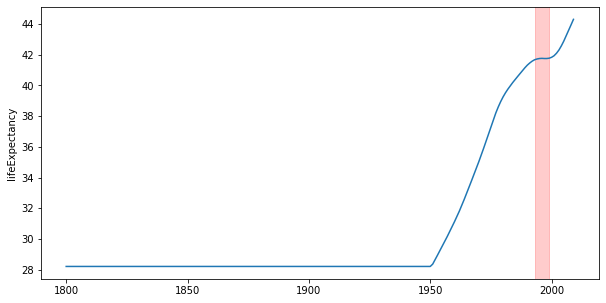

/Users/hirotanaka/.pyenv/versions/miniconda3-4.3.30/envs/tdb/lib/python3.7/site-packages/ipykernel_launcher.py:48: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


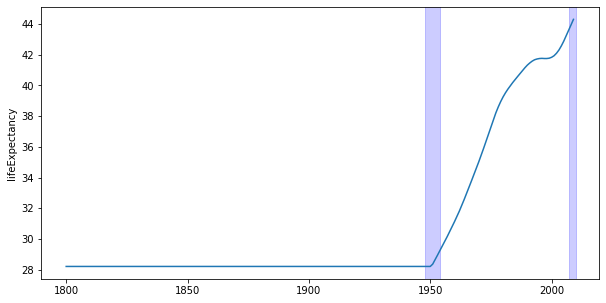

/Users/hirotanaka/.pyenv/versions/miniconda3-4.3.30/envs/tdb/lib/python3.7/site-packages/ipykernel_launcher.py:48: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


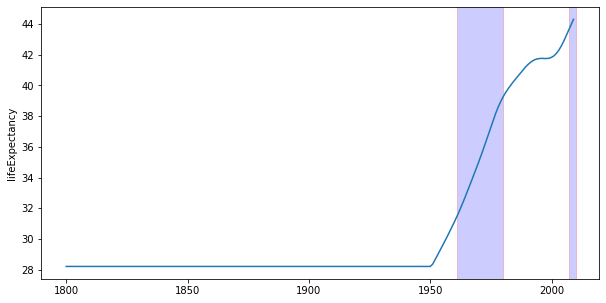

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

ind = 'lifeExpectancy'
# ind = 'income'
window_size_A = 6
window_size_B = 4
window_size_C = 4

g = new_nations.groupby('name')
for k in g.groups.keys():
    df = g.get_group(k).sort_values('year').set_index('year').interpolate('time')
    break
ys = df[ind]


fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
sns.lineplot(x=range(1800, 2010), y=ind, data=df)
for from_, to_, ptype in A(ys, window_size_A):
    from_ += 1800
    to_ += 1800
    ax.add_patch(pat.Rectangle(xy=(from_, 0), width=to_-from_, height=1200, color='red', alpha=0.2))
    x = (from_+to_)/2
    # plt.plot([x, x], [0, 1200])
plt.show()


fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
sns.lineplot(x=range(1800, 2010), y=ind, data=df)
for from_, to_, ptype in B(ys, window_size_B, k_sigma=3):
    from_ += 1800
    to_ += 1800
    ax.add_patch(pat.Rectangle(xy=(from_, 0), width=to_-from_, height=1200, color='blue', alpha=0.2))
    x = (from_+to_)/2
    # plt.plot([x, x], [0, 1200])
plt.show()


fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
sns.lineplot(x=range(1800, 2010), y=ind, data=df)
for from_, to_, ptype in large_grad(ys, window_size_C, k_sigma=2):
    from_ += 1800
    to_ += 1800
    ax.add_patch(pat.Rectangle(xy=(from_, 0), width=to_-from_, height=1200, facecolor='blue', edgecolor='red', alpha=0.2))
    x = (from_+to_)/2
    # plt.plot([x, x], [0, 1200])
plt.show()

In [6]:
template = "{country}'s {ind} has {ptype} ({from_} ~ {to_})\n"
template_A = "{country}'s {ind} has peak from {from_} to {to_}\n"
template_B = "{country}'s {ind}'s tread has changed from {from_} to {to_}\n"

In [7]:
def datafact2text(country, ind, from_, to_, ptype):
    return template.format(country=country, ind=ind, from_=from_, to_=to_, ptype=ptype)


def datafacts2json(datafacts, fname=None):
    ret = []
    pre_country = None
    for country, ind, from_, to_, ptype in datafacts:
        if pre_country != country:
            d_ = {'text': country, 'focusArgs': [None, [country]]}
            d_.update(dict(country=country, ind=None, from_=None, to_=None, ptype=None))
            ret.append(d_)
            pre_country = country
        d_ = {'text': template.format(country=country, ind=ind, from_=from_, to_=to_, ptype=ptype),
                'focusArgs': [[from_, to_], [country]]}
        d_.update(dict(country=country, ind=ind, from_=from_, to_=to_, ptype=ptype))
        ret.append(d_)
    if fname is not None:
        with open(fname, 'w') as  f:
            json_text = json.dumps(ret)
            f.write(json_text)
    return ret

def get_datafacts(df, inds='income population lifeExpectancy'.split(), window_size_A=6, window_size_B=4, window_size_C=4):
    g = df.groupby('name')
    ret = []
    for country in tqdm(g.groups.keys()):
        df_ = g.get_group(country).sort_values('year').set_index('year').interpolate('time')
        for ind in inds:
            ys = df_[ind]
            for from_, to_, ptype in A(ys, window_size_A):
                from_ += 1800
                to_ += 1800
                ret.append((country, ind, from_, to_, ptype))
            for from_, to_, ptype in B(ys, window_size_B):
                from_ += 1800
                to_ += 1800
                ret.append((country, ind, from_, to_, ptype))
            for from_, to_, ptype in large_grad(ys, window_size_C):
                from_ += 1800
                to_ += 1800
                ret.append((country, ind, from_, to_, ptype))
    return ret

In [8]:
datafacts = get_datafacts(new_nations)
len(datafacts)

/Users/hirotanaka/.pyenv/versions/miniconda3-4.3.30/envs/tdb/lib/python3.7/site-packages/ipykernel_launcher.py:48: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


3607

In [9]:
datafacts

[('Afghanistan', 'income', 1953, 1959, 'peak'),
 ('Afghanistan', 'income', 1974, 1989, 'vibration'),
 ('Afghanistan', 'income', 1998, 2004, 'valley'),
 ('Afghanistan', 'income', 1970, 1974, 'trend_increase'),
 ('Afghanistan', 'income', 1984, 1990, 'trend_confusion'),
 ('Afghanistan', 'income', 1992, 1996, 'trend_increase'),
 ('Afghanistan', 'income', 1999, 2005, 'trend_confusion'),
 ('Afghanistan', 'income', 1979, 1984, 'pos_grad'),
 ('Afghanistan', 'income', 1985, 1995, 'neg_grad'),
 ('Afghanistan', 'income', 2000, 2010, 'pos_grad'),
 ('Afghanistan', 'population', 1976, 1985, 'vibration'),
 ('Afghanistan', 'population', 1978, 1985, 'trend_confusion'),
 ('Afghanistan', 'population', 1989, 1996, 'trend_confusion'),
 ('Afghanistan', 'population', 1999, 2004, 'trend_increase'),
 ('Afghanistan', 'population', 1979, 1984, 'neg_grad'),
 ('Afghanistan', 'population', 1990, 1997, 'pos_grad'),
 ('Afghanistan', 'population', 2000, 2009, 'pos_grad'),
 ('Afghanistan', 'lifeExpectancy', 1993, 1999,

In [11]:
datafactsjson = datafacts2json(datafacts, fname='../public/nations_change2.json')
datafactsjson

[{'text': 'Afghanistan',
  'focusArgs': [None, ['Afghanistan']],
  'country': 'Afghanistan',
  'ind': None,
  'from_': None,
  'to_': None,
  'ptype': None},
 {'text': "Afghanistan's income has peak (1953 ~ 1959)\n",
  'focusArgs': [[1953, 1959], ['Afghanistan']],
  'country': 'Afghanistan',
  'ind': 'income',
  'from_': 1953,
  'to_': 1959,
  'ptype': 'peak'},
 {'text': "Afghanistan's income has vibration (1974 ~ 1989)\n",
  'focusArgs': [[1974, 1989], ['Afghanistan']],
  'country': 'Afghanistan',
  'ind': 'income',
  'from_': 1974,
  'to_': 1989,
  'ptype': 'vibration'},
 {'text': "Afghanistan's income has valley (1998 ~ 2004)\n",
  'focusArgs': [[1998, 2004], ['Afghanistan']],
  'country': 'Afghanistan',
  'ind': 'income',
  'from_': 1998,
  'to_': 2004,
  'ptype': 'valley'},
 {'text': "Afghanistan's income has trend_increase (1970 ~ 1974)\n",
  'focusArgs': [[1970, 1974], ['Afghanistan']],
  'country': 'Afghanistan',
  'ind': 'income',
  'from_': 1970,
  'to_': 1974,
  'ptype': 'tr

In [12]:
# TODO: テーブル作って
#
def find_related_datafacts(datafact, datafacts):
    ret = defaultdict(list)
    for d in datafacts:
        cnt = 0
        for k in datafact.keys():
            cnt += d[k]==datafact[k]
        ret[cnt].append(d)
    return ret
rf = find_related_datafacts(datafactsjson[3], datafactsjson)
rf.keys()

dict_keys([1, 2, 7, 0, 3, 4])

In [13]:
def find_time_related_datafacts(datafact, datafacts, rate=0.5):
    ret = []
    from_, to_ = datafact['from_'], datafact['to_']
    if from_ is None or to_ is None:
        return
    for d in datafacts:
        from_d, to_d = d['from_'], d['to_']
        if from_d is None or to_d is None:
            continue
        and_ts = max(0, min(to_, to_d)-max(from_, from_d))
        or_ts = max(0, max(to_, to_d)-min(from_, from_d)) # 重複なしならand_ts=0なので考えないで良い
        if and_ts/or_ts>=rate and d!=datafact:
            ret.append(d)
    return ret

In [14]:
def find_country_related_datafacts(datafact, datafacts):
    ret = []
    country = datafact['country']
    for d in datafacts:
        if d['country']==country and d!=datafact:
            ret.append(d)
    return ret

def find_ind_related_datafacts(datafact, datafacts, rate=0.8):
    ret = []
    ind = datafact['ind']
    for d in datafacts:
        if d['ind']==ind and d!=datafact:
            ret.append(d)
    return ret

def find_ptype_related_datafacts(datafact, datafacts, rate=0.8):
    ret = []
    ptype = datafact['ptype']
    for d in datafacts:
        if d['ptype']==ptype and d!=datafact:
            ret.append(d)
    return ret

In [15]:
def print_datafacts(datafacts):
    print(*map(lambda x: x['text'], datafacts), sep='\n')

In [16]:
def show_related_datafacts(datafact, datafacts):
    time_related = find_time_related_datafacts(datafact, datafacts)
    print('time related')
    # print_datafacts(time_related)
    print('time ind ptype related')
    print_datafacts(find_ind_related_datafacts(datafact, find_ptype_related_datafacts(datafact, time_related)))
    print('time ind related')
    print_datafacts(find_ind_related_datafacts(datafact,time_related))
    
    country_related = find_country_related_datafacts(datafact, datafacts)
    print('country related')
    # print_datafacts(country_related)
    print('country ind ptype related')
    print_datafacts(find_ind_related_datafacts(datafact, find_ptype_related_datafacts(datafact, country_related)))
    print('country ind related')
    print_datafacts(find_ind_related_datafacts(datafact,country_related))
    print('country time related')
    print_datafacts(find_time_related_datafacts(datafact, country_related))

- datafact間のedge
    - 同時期のdatafact
        - 同時期同指標、同理由のdatafact(同じ動きをした国)
        - その他(一方で、…)
        - (A かつ b)/(aまたはb)で時期の一致度
    - 同国のdatafact
        - 同指標、同理由
            - 同じことが何時ごろ…
        - 同指標
            - そのご…
        - 同時期、同理由
            - AとBは…


In [20]:
for i in range(3, 100):
    if datafactsjson[i]['country']!='Afghanistan':
        break
    print(datafactsjson[i])

{'text': "Afghanistan's income has valley (1998 ~ 2004)\n", 'focusArgs': [[1998, 2004], ['Afghanistan']], 'country': 'Afghanistan', 'ind': 'income', 'from_': 1998, 'to_': 2004, 'ptype': 'valley'}
{'text': "Afghanistan's income has trend_increase (1970 ~ 1974)\n", 'focusArgs': [[1970, 1974], ['Afghanistan']], 'country': 'Afghanistan', 'ind': 'income', 'from_': 1970, 'to_': 1974, 'ptype': 'trend_increase'}
{'text': "Afghanistan's income has trend_confusion (1984 ~ 1990)\n", 'focusArgs': [[1984, 1990], ['Afghanistan']], 'country': 'Afghanistan', 'ind': 'income', 'from_': 1984, 'to_': 1990, 'ptype': 'trend_confusion'}
{'text': "Afghanistan's income has trend_increase (1992 ~ 1996)\n", 'focusArgs': [[1992, 1996], ['Afghanistan']], 'country': 'Afghanistan', 'ind': 'income', 'from_': 1992, 'to_': 1996, 'ptype': 'trend_increase'}
{'text': "Afghanistan's income has trend_confusion (1999 ~ 2005)\n", 'focusArgs': [[1999, 2005], ['Afghanistan']], 'country': 'Afghanistan', 'ind': 'income', 'from_':

In [18]:
datafact = datafactsjson[3]
print(datafact)
show_related_datafacts(datafact, datafactsjson)

{'text': "Afghanistan's income has valley (1998 ~ 2004)\n", 'focusArgs': [[1998, 2004], ['Afghanistan']], 'country': 'Afghanistan', 'ind': 'income', 'from_': 1998, 'to_': 2004, 'ptype': 'valley'}
time related
time ind ptype related
Congo, Dem. Rep.'s income has valley (1998 ~ 2004)

Indonesia's income has valley (1996 ~ 2002)

New Caledonia's income has valley (1996 ~ 2002)

Nigeria's income has valley (1999 ~ 2005)

Solomon Islands's income has valley (1999 ~ 2005)

Uruguay's income has valley (1999 ~ 2005)

time ind related
Afghanistan's income has trend_confusion (1999 ~ 2005)

Argentina's income has neg_grad (1998 ~ 2004)

Aruba's income has neg_grad (2000 ~ 2004)

Bangladesh's income has pos_grad (1998 ~ 2010)

Belize's income has trend_confusion (1996 ~ 2006)

Belize's income has pos_grad (1997 ~ 2005)

Benin's income has pos_grad (1998 ~ 2004)

Burkina Faso's income has peak (1996 ~ 2002)

Canada's income has pos_grad (1996 ~ 2002)

Colombia's income has vibration (1996 ~ 2003)


In [78]:
print(datafact)

{'text': "Argentina's lifeExpectancy has vibration (1882 ~ 1898)\n", 'focusArgs': [[1882, 1898], ['Argentina']], 'country': 'Argentina', 'ind': 'lifeExpectancy', 'from_': 1882, 'to_': 1898, 'ptype': 'vibration'}


In [ ]:
datafacts

In [93]:
Counter(map(lambda x: x['ptype'], datafactsjson))

Counter({None: 180,
         'peak': 387,
         'vibration': 347,
         'valley': 251,
         'trend_increase': 297,
         'trend_confusion': 503,
         'pos_grad': 975,
         'neg_grad': 450,
         'trend_decrease': 397})

In [94]:
Counter(map(lambda x: x['ind'], datafactsjson))

Counter({None: 180, 'income': 1721, 'population': 879, 'lifeExpectancy': 1007})

In [86]:
from collections import Counter
c = Counter(map(lambda x: (x['ptype'], x['ind']), datafactsjson))
c

Counter({(None, None): 180,
         ('peak', 'income'): 231,
         ('vibration', 'income'): 181,
         ('valley', 'income'): 140,
         ('trend_increase', 'income'): 85,
         ('trend_confusion', 'income'): 234,
         ('pos_grad', 'income'): 434,
         ('neg_grad', 'income'): 290,
         ('vibration', 'population'): 102,
         ('trend_confusion', 'population'): 146,
         ('trend_increase', 'population'): 78,
         ('neg_grad', 'population'): 59,
         ('pos_grad', 'population'): 249,
         ('peak', 'lifeExpectancy'): 104,
         ('trend_increase', 'lifeExpectancy'): 134,
         ('trend_decrease', 'lifeExpectancy'): 113,
         ('pos_grad', 'lifeExpectancy'): 292,
         ('trend_decrease', 'population'): 158,
         ('vibration', 'lifeExpectancy'): 64,
         ('trend_decrease', 'income'): 126,
         ('valley', 'lifeExpectancy'): 76,
         ('trend_confusion', 'lifeExpectancy'): 123,
         ('neg_grad', 'lifeExpectancy'): 101,
     

{'valley': 0, 'neg_grad': 1, None: 2, 'trend_confusion': 3, 'trend_decrease': 4, 'pos_grad': 5, 'trend_increase': 6, 'vibration': 7, 'peak': 8}
{'lifeExpectancy': 0, 'income': 1, 'population': 2, None: 3}


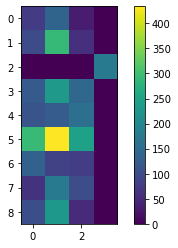

In [92]:
k1 = {k: i for i, k in enumerate(set(map(lambda x: x[0], c.keys())))}
k2 = {k: i for i, k in enumerate(set(map(lambda x: x[1], c.keys())))}
m = np.zeros((len(k1.keys()), len(k2.keys())))
for (k1_, k2_), v in c.items():
    m[k1[k1_], k2[k2_]] = v
print(k1)
print(k2)
plt.imshow(m); plt.colorbar(); plt.show()

In [87]:
c.items()

dict_items([((None, None), 180), (('peak', 'income'), 231), (('vibration', 'income'), 181), (('valley', 'income'), 140), (('trend_increase', 'income'), 85), (('trend_confusion', 'income'), 234), (('pos_grad', 'income'), 434), (('neg_grad', 'income'), 290), (('vibration', 'population'), 102), (('trend_confusion', 'population'), 146), (('trend_increase', 'population'), 78), (('neg_grad', 'population'), 59), (('pos_grad', 'population'), 249), (('peak', 'lifeExpectancy'), 104), (('trend_increase', 'lifeExpectancy'), 134), (('trend_decrease', 'lifeExpectancy'), 113), (('pos_grad', 'lifeExpectancy'), 292), (('trend_decrease', 'population'), 158), (('vibration', 'lifeExpectancy'), 64), (('trend_decrease', 'income'), 126), (('valley', 'lifeExpectancy'), 76), (('trend_confusion', 'lifeExpectancy'), 123), (('neg_grad', 'lifeExpectancy'), 101), (('valley', 'population'), 35), (('peak', 'population'), 52)])

In [57]:
datafactsjson[3]==datafactsjson[3]

True

In [54]:
find_time_related_datafacts(datafactsjson[3], datafactsjson)

[{'text': "Afghanistan's income has valley (1998 ~ 2004)\n",
  'focusArgs': [[1998, 2004], ['Afghanistan']],
  'country': 'Afghanistan',
  'ind': 'income',
  'from_': 1998,
  'to_': 2004,
  'ptype': 'valley'},
 {'text': "Afghanistan's population has trend_increase (1999 ~ 2004)\n",
  'focusArgs': [[1999, 2004], ['Afghanistan']],
  'country': 'Afghanistan',
  'ind': 'population',
  'from_': 1999,
  'to_': 2004,
  'ptype': 'trend_increase'},
 {'text': "Argentina's income has neg_grad (1998 ~ 2004)\n",
  'focusArgs': [[1998, 2004], ['Argentina']],
  'country': 'Argentina',
  'ind': 'income',
  'from_': 1998,
  'to_': 2004,
  'ptype': 'neg_grad'},
 {'text': "Benin's income has pos_grad (1998 ~ 2004)\n",
  'focusArgs': [[1998, 2004], ['Benin']],
  'country': 'Benin',
  'ind': 'income',
  'from_': 1998,
  'to_': 2004,
  'ptype': 'pos_grad'},
 {'text': "Congo, Dem. Rep.'s income has valley (1998 ~ 2004)\n",
  'focusArgs': [[1998, 2004], ['Congo, Dem. Rep.']],
  'country': 'Congo, Dem. Rep.',


In [29]:
rf[2]

[{'text': "Afghanistan's income has peak (1953 ~ 1959)\n",
  'focusArgs': [[1953, 1959], ['Afghanistan']],
  'country': 'Afghanistan',
  'ind': 'income',
  'from_': 1953,
  'to_': 1959,
  'ptype': 'peak'},
 {'text': "Afghanistan's income has vibration (1974 ~ 1989)\n",
  'focusArgs': [[1974, 1989], ['Afghanistan']],
  'country': 'Afghanistan',
  'ind': 'income',
  'from_': 1974,
  'to_': 1989,
  'ptype': 'vibration'},
 {'text': "Afghanistan's income has trend_increase (1970 ~ 1974)\n",
  'focusArgs': [[1970, 1974], ['Afghanistan']],
  'country': 'Afghanistan',
  'ind': 'income',
  'from_': 1970,
  'to_': 1974,
  'ptype': 'trend_increase'},
 {'text': "Afghanistan's income has trend_confusion (1984 ~ 1990)\n",
  'focusArgs': [[1984, 1990], ['Afghanistan']],
  'country': 'Afghanistan',
  'ind': 'income',
  'from_': 1984,
  'to_': 1990,
  'ptype': 'trend_confusion'},
 {'text': "Afghanistan's income has trend_increase (1992 ~ 1996)\n",
  'focusArgs': [[1992, 1996], ['Afghanistan']],
  'coun

In [34]:
window_size_A = 6
window_size_B = 4
window_size_C = 4

g = new_nations.groupby('name')
data = []
for country in tqdm(g.groups.keys()):
    df = g.get_group(country).sort_values('year').set_index('year').interpolate('time')
    data.append({'text': country,
                'focusArgs': [None, [country]]})
    for ind in 'income population lifeExpectancy'.split():
        ys = df[ind]
        for from_, to_, ptype in A(ys, window_size_A):
            from_ += 1800
            to_ += 1800
            d_ = {'text': template.format(country=country, ind=ind, from_=from_, to_=to_, ptype=ptype),
                'focusArgs': [[from_, to_], [country]]}
            data.append(d_)
        for from_, to_, ptype in B(ys, window_size_B):
            from_ += 1800
            to_ += 1800
            d_ = {'text': template.format(country=country, ind=ind, from_=from_, to_=to_, ptype=ptype),
                'focusArgs': [[from_, to_], [country]]}
            data.append(d_)
        for from_, to_, ptype in large_grad(ys, window_size_C):
            from_ += 1800
            to_ += 1800
            d_ = {'text': template.format(country=country, ind=ind, from_=from_, to_=to_, ptype=ptype),
                'focusArgs': [[from_, to_], [country]]}
            data.append(d_)
"""
with open('../public/afghan.json', 'w') as  f:
    json_text = json.dumps(data)
    f.write(json_text)
"""
len(data)

/Users/hirotanaka/.pyenv/versions/miniconda3-4.3.30/envs/tdb/lib/python3.7/site-packages/ipykernel_launcher.py:48: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


3094

In [26]:
data

[{'text': 'Afghanistan', 'focusArgs': [None, ['Afghanistan']]},
 {'text': "Afghanistan's income has peak (1953 ~ 1959)\n",
  'focusArgs': [[1953, 1959], ['Afghanistan']]},
 {'text': "Afghanistan's income has vibration (1974 ~ 1989)\n",
  'focusArgs': [[1974, 1989], ['Afghanistan']]},
 {'text': "Afghanistan's income has valley (1998 ~ 2004)\n",
  'focusArgs': [[1998, 2004], ['Afghanistan']]},
 {'text': "Afghanistan's income has trend_increase (1970 ~ 1974)\n",
  'focusArgs': [[1970, 1974], ['Afghanistan']]},
 {'text': "Afghanistan's income has trend_confusion (1984 ~ 1990)\n",
  'focusArgs': [[1984, 1990], ['Afghanistan']]},
 {'text': "Afghanistan's income has trend_increase (1992 ~ 1996)\n",
  'focusArgs': [[1992, 1996], ['Afghanistan']]},
 {'text': "Afghanistan's income has trend_confusion (1999 ~ 2005)\n",
  'focusArgs': [[1999, 2005], ['Afghanistan']]},
 {'text': "Afghanistan's income has pos_grad (1980 ~ 1984)\n",
  'focusArgs': [[1980, 1984], ['Afghanistan']]},
 {'text': "Afghanis

In [25]:
with open('../public/nations_change.json', 'w') as  f:
    json_text = json.dumps(data)
    f.write(json_text)

In [116]:
with open('../public/afghan.json') as  f:
    tmp = json.load(f)
tmp

[{'text': "Afghanistan's income has peak from 181 to 185",
  'focus_args': [[181, 185], ['Afghanistan']]},
 {'text': "Afghanistan's income has peak from 175 to 179",
  'focus_args': [[175, 179], ['Afghanistan']]},
 {'text': "Afghanistan's income has peak from 197 to 201",
  'focus_args': [[197, 201], ['Afghanistan']]},
 {'text': "Afghanistan's income has peak from 164 to 168",
  'focus_args': [[164, 168], ['Afghanistan']]},
 {'text': "Afghanistan's income has peak from 154 to 158",
  'focus_args': [[154, 158], ['Afghanistan']]},
 {'text': "Afghanistan's income's tread has changed from 178 to 183",
  'focus_args': [[178, 183], ['Afghanistan']]},
 {'text': "Afghanistan's income's tread has changed from 180 to 185",
  'focus_args': [[180, 185], ['Afghanistan']]},
 {'text': "Afghanistan's income's tread has changed from 181 to 186",
  'focus_args': [[181, 186], ['Afghanistan']]},
 {'text': "Afghanistan's income's tread has changed from 183 to 188",
  'focus_args': [[183, 188], ['Afghanista